Epoch [1] - Train Loss: 0.1448, Val Loss: 0.0653
              Train L1: 0.1448,  Val L1: 0.0653
Epoch [2] - Train Loss: 0.0455, Val Loss: 0.0306
              Train L1: 0.0455,  Val L1: 0.0306
Epoch [3] - Train Loss: 0.0266, Val Loss: 0.0209
              Train L1: 0.0266,  Val L1: 0.0209
Epoch [4] - Train Loss: 0.0206, Val Loss: 0.0166
              Train L1: 0.0206,  Val L1: 0.0166
Epoch [5] - Train Loss: 0.0167, Val Loss: 0.0144
              Train L1: 0.0167,  Val L1: 0.0144
Epoch [6] - Train Loss: 0.0152, Val Loss: 0.0134
              Train L1: 0.0152,  Val L1: 0.0134
Epoch [7] - Train Loss: 0.0143, Val Loss: 0.0126
              Train L1: 0.0143,  Val L1: 0.0126
Epoch [8] - Train Loss: 0.0137, Val Loss: 0.0123
              Train L1: 0.0137,  Val L1: 0.0123
Epoch [9] - Train Loss: 0.0132, Val Loss: 0.0118
              Train L1: 0.0132,  Val L1: 0.0118
Epoch [10] - Train Loss: 0.0129, Val Loss: 0.0114
              Train L1: 0.0129,  Val L1: 0.0114
Epoch [11] - Train Loss: 0.01

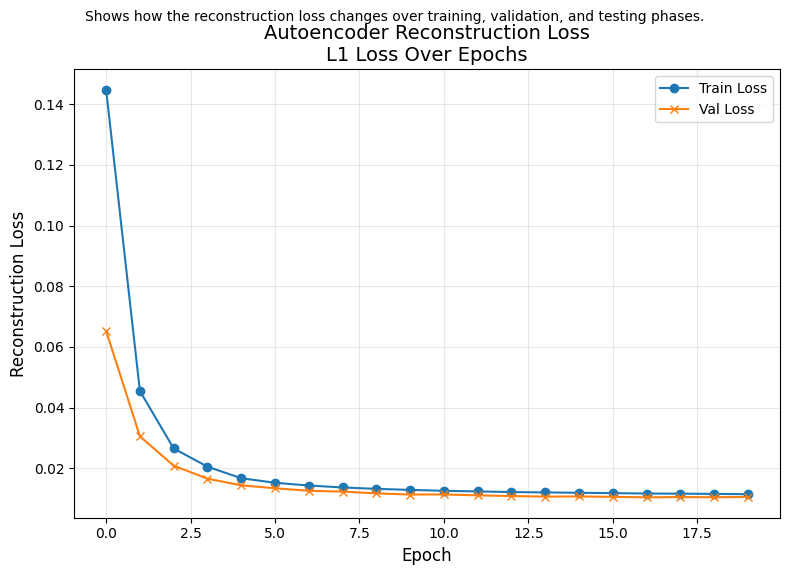

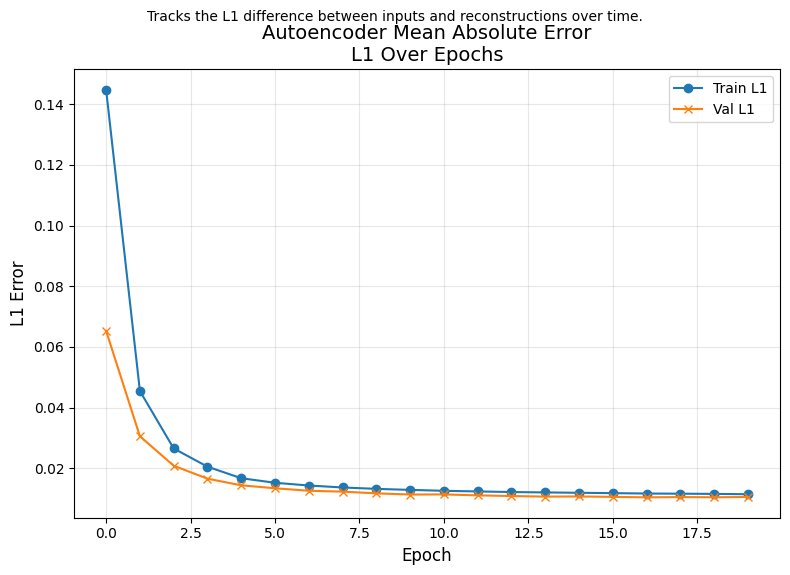

=== Final Autoencoder Metrics ===
Train ReconLoss: 0.0115
Val   ReconLoss: 0.0106
Train L1: 0.0115
Val   L1: 0.0106


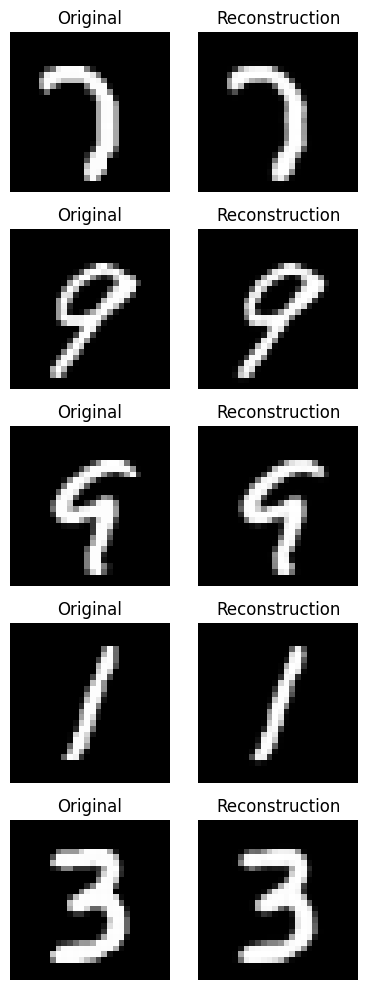

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('..')

from models.mnist_autoencoder import MNISTAutoencoder
from trainers.autoencoder_trainer import AutoencoderTrainer
from models.mnist_classifier import MNISTClassifier
from trainers.classifier_trainer import ClassifierTrainer

def show_ae_reconstructions(model, dataset, device='cuda', num_images=5):
    model.eval()  
    indices = np.random.choice(len(dataset), size=num_images, replace=False)

    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(4, 2*num_images))

    for i, idx in enumerate(indices):
        img, _ = dataset[idx]  
        img_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            reconstruction, _ = model(img_tensor) 

        original_np = img_tensor.cpu().squeeze().numpy()
        recon_np = reconstruction.cpu().squeeze().numpy()

        if len(original_np.shape) == 3:
            original_np = original_np[0] 
        if len(recon_np.shape) == 3:
            recon_np = recon_np[0]

        axes[i, 0].imshow(original_np, cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(recon_np, cmap='gray')
        axes[i, 1].set_title("Reconstruction")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()



data_path = "/datasets/cv_datasets/data"

# Data transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.ToTensor()
])
val_transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root=data_path, train=True,  download=False, transform=train_transform)
val_dataset   = datasets.MNIST(root=data_path, train=False, download=False, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

autoencoder_l1_loss = MNISTAutoencoder(latent_dim=128).to(device)

autoencoder_trainer = AutoencoderTrainer(
    model=autoencoder_l1_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.L1Loss(),
    device=device,
    lr=1e-4,
    num_epochs=60,
    weight_decay=1e-4
)

autoencoder_trainer.train()
autoencoder_trainer.plot_metrics()

show_ae_reconstructions(autoencoder_l1_loss, val_dataset, device=device, num_images=5)


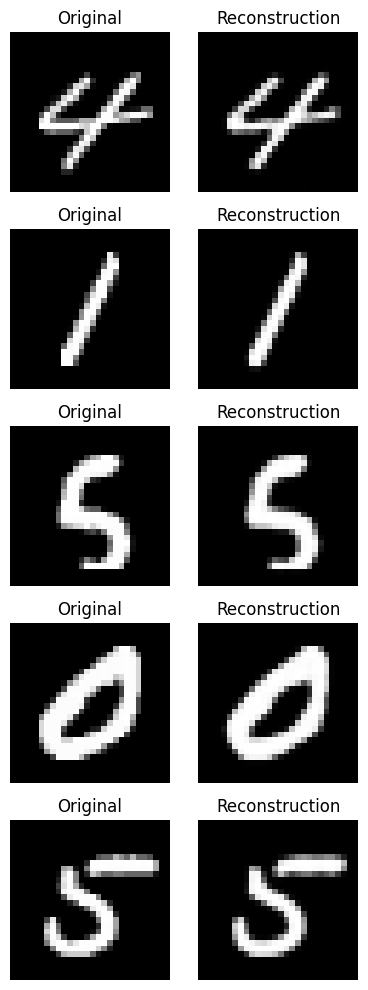

In [2]:
show_ae_reconstructions(autoencoder_l1_loss, val_dataset, device=device, num_images=5)


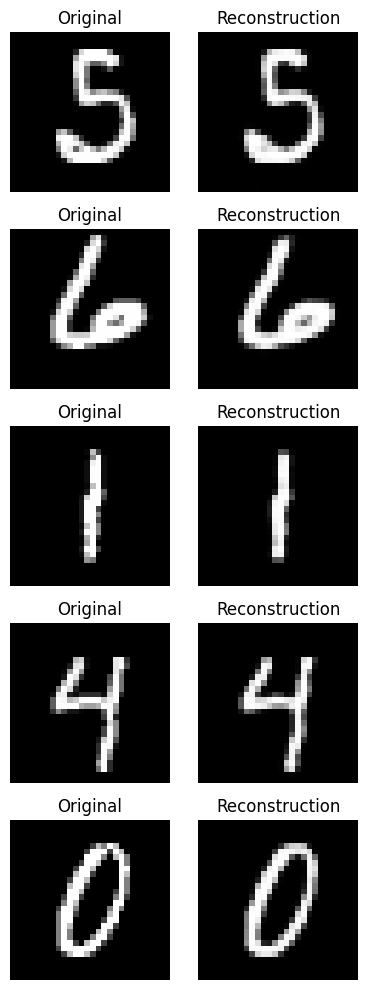

In [3]:
show_ae_reconstructions(autoencoder_l1_loss, val_dataset, device=device, num_images=5)


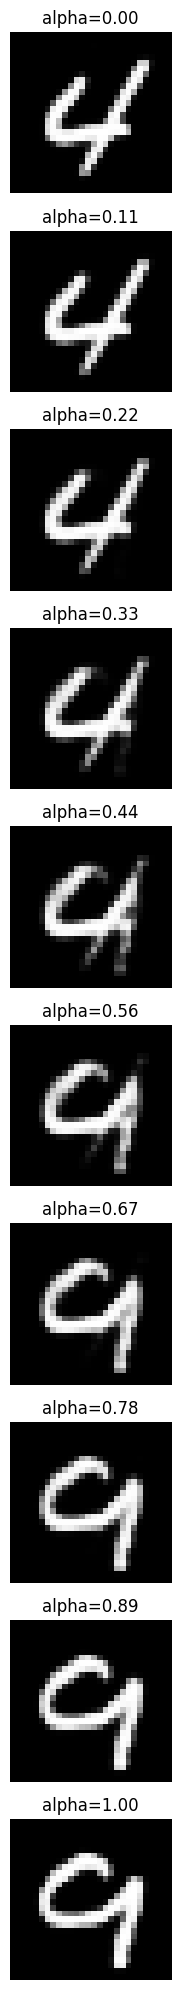

In [ ]:
def latent_interpolation(ae_model, dataset, device='cuda', num_steps=10):
    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    ae_model.eval()
    indices = np.random.choice(len(dataset), size=2, replace=False)

    img1, _ = dataset[indices[0]]
    img2, _ = dataset[indices[1]]

    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    with torch.no_grad():
        _, z1 = ae_model(img1)
        _, z2 = ae_model(img2)

    z1 = z1.squeeze(0)  
    z2 = z2.squeeze(0)  

    alphas = np.linspace(0, 1, num_steps)
    decoded_imgs = []

    for alpha in alphas:
        z_interp = (1 - alpha) * z1 + alpha * z2
        z_interp = z_interp.unsqueeze(0)
        with torch.no_grad():
            recon_interp = ae_model.decoder(z_interp)
        decoded_imgs.append(recon_interp.squeeze(0).cpu())
    fig, axes = plt.subplots(nrows=num_steps, ncols=1, figsize=(3, 2 * num_steps))
    for i in range(num_steps):
        img_np = decoded_imgs[i].squeeze().numpy()
        axes[i].imshow(img_np, cmap='gray')
        axes[i].set_title(f"alpha={alphas[i]:.2f}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

latent_interpolation(autoencoder_l1_loss, val_dataset, device='cuda', num_steps=10)



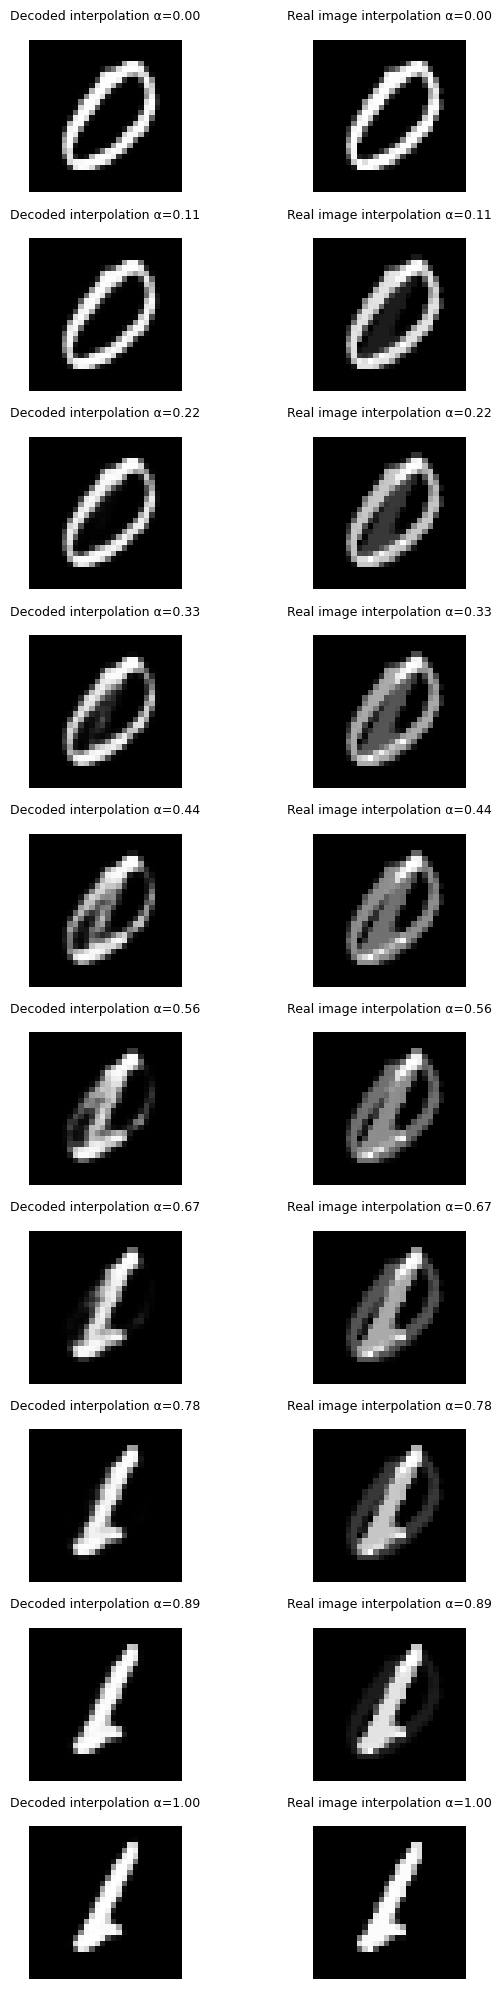

In [17]:
def latent_interpolation(ae_model, dataset, device='cuda', num_steps=10):
    """
    Compare autoencoder latent-space interpolation vs. direct pixel interpolation,
    arranged vertically (each row is one alpha-step).

    Titles now have extra 'pad' so they don't overlap the images or each other.
    """
    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    ae_model.eval()

    # 1) randomly select 2 images
    idxs = np.random.choice(len(dataset), size=2, replace=False)
    img1, _ = dataset[idxs[0]]
    img2, _ = dataset[idxs[1]]

    # shape: (C,H,W). Add batch dim, move to device
    img1_tensor = img1.unsqueeze(0).to(device)
    img2_tensor = img2.unsqueeze(0).to(device)

    # encode each
    with torch.no_grad():
        _, z1 = ae_model(img1_tensor)
        _, z2 = ae_model(img2_tensor)
    z1 = z1.squeeze(0)  # shape [latent_dim]
    z2 = z2.squeeze(0)

    latent_interp_imgs = []
    pixel_interp_imgs = []

    alphas = np.linspace(0, 1, num_steps)

    # Latent interpolation
    for alpha in alphas:
        z_interp = (1 - alpha)*z1 + alpha*z2
        z_interp = z_interp.unsqueeze(0)
        with torch.no_grad():
            recon_interp = ae_model.decoder(z_interp)
        latent_interp_imgs.append(recon_interp.squeeze(0).cpu())

    # Pixel interpolation
    img1_cpu = img1_tensor.squeeze(0).cpu()
    img2_cpu = img2_tensor.squeeze(0).cpu()
    for alpha in alphas:
        mixed = (1-alpha)*img1_cpu + alpha*img2_cpu
        pixel_interp_imgs.append(mixed)

    # Plot them vertically
    fig, axes = plt.subplots(nrows=num_steps, ncols=2, figsize=(7, 2*num_steps))

    for i in range(num_steps):
        # Latent in [i, 0]
        lat_img = latent_interp_imgs[i].squeeze().numpy()
        if len(lat_img.shape) == 3:
            lat_img = lat_img[0]  # remove channel
        axes[i, 0].imshow(lat_img, cmap='gray')
        axes[i, 0].set_title(f"Decoded interpolation α={alphas[i]:.2f}",
                             fontsize=9, pad=15)
        axes[i, 0].axis('off')

        # Pixel in [i, 1]
        pix_img = pixel_interp_imgs[i].squeeze().numpy()
        if len(pix_img.shape) == 3:
            pix_img = pix_img[0]
        axes[i, 1].imshow(pix_img, cmap='gray')
        axes[i, 1].set_title(f"Real image interpolation α={alphas[i]:.2f}",
                             fontsize=9, pad=15)
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
latent_interpolation(autoencoder_l1_loss, val_dataset, device='cuda', num_steps=10)
